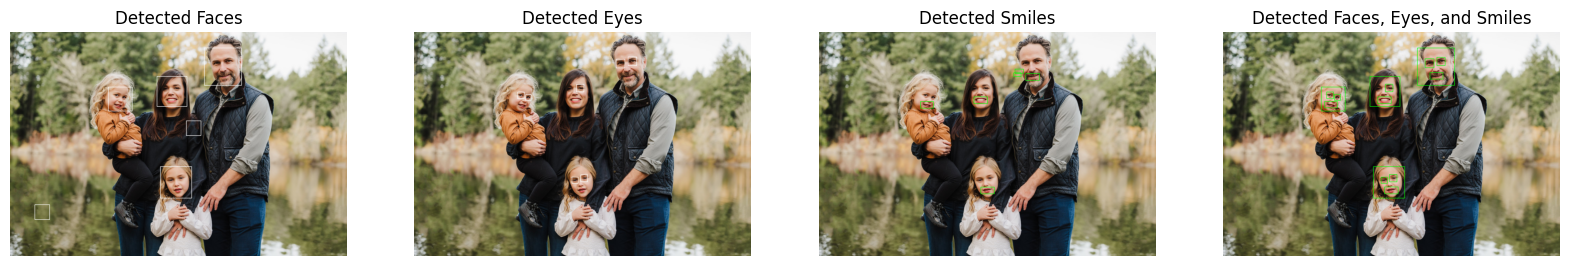

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc vào bộ phân loại cascade cho mặt, mắt và nụ cười
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')

# Hàm phát hiện khuôn mặt đã điều chỉnh
def adjusted_detect_face(img):
    face_img = img.copy()
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)  # Chuyển đổi ảnh sang thang độ xám.
    gray = cv2.equalizeHist(gray)  # Cân bằng histogram để tăng độ tương phản.

    face_rect = face_cascade.detectMultiScale(gray,
                                              scaleFactor=1.1,
                                              minNeighbors=5,
                                              minSize=(30, 30),
                                              maxSize=(300, 300))  # Đặt kích thước tối đa để bỏ qua các phát hiện rất lớn

    filtered_faces = []
    for (x, y, w, h) in face_rect:
        # Kiểm tra tỷ lệ khung hình để lọc ra các đối tượng không phải khuôn mặt
        aspect_ratio = w / float(h)
        if 0.75 < aspect_ratio < 1.3:
            filtered_faces.append((x, y, w, h))
            cv2.rectangle(face_img, (x, y), (x + w, y + h), (255, 255, 255), 2)  # Vẽ hình chữ nhật quanh khuôn mặt

    return face_img, filtered_faces

# Hàm phát hiện mắt
def detect_eyes(img, face_rects):
    eye_img = img.copy()
    gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Cân bằng histogram để tăng độ tương phản

    valid_faces = []
    for (fx, fy, fw, fh) in face_rects:
        roi_gray = gray[fy:fy + fh, fx:fx + fw]
        roi_color = eye_img[fy:fy + fh, fx:fx + fw]
        
        eye_rect = eye_cascade.detectMultiScale(roi_gray,
                                                scaleFactor=1.1,
                                                minNeighbors=5,
                                                minSize=(20, 20),
                                                maxSize=(80, 80))  # Đặt kích thước tối đa để bỏ qua các phát hiện rất lớn
        
        # Chỉ lấy các phát hiện mắt bên trong khuôn mặt
        eyes = []
        for (ex, ey, ew, eh) in eye_rect:
            # Chỉ lấy các phát hiện trong nửa trên của vùng khuôn mặt
            if ey < fh / 2 and ew > 10 and eh > 10:  # Bỏ qua những phát hiện quá nhỏ
                eyes.append((ex, ey, ew, eh))
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (255, 255, 255), 2)  # Vẽ hình chữ nhật quanh mắt

        # Ít nhất 1 mắt được phát hiện thì đó là khuôn mặt hợp lệ
        if len(eyes) >= 1:
            valid_faces.append((fx, fy, fw, fh))

    return eye_img, valid_faces

# Hàm phát hiện nụ cười
def detect_smiles(img, face_rects):
    smile_img = img.copy()
    gray = cv2.cvtColor(smile_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Cân bằng histogram để tăng độ tương phản

    for (fx, fy, fw, fh) in face_rects:
        # Chỉ tập trung vào nửa dưới của khuôn mặt để phát hiện nụ cười
        roi_gray = gray[fy + fh//2:fy + fh, fx:fx + fw]
        roi_color = smile_img[fy + fh//2:fy + fh, fx:fx + fw]
        
        smile_rect = smile_cascade.detectMultiScale(roi_gray,
                                                    scaleFactor=1.1,
                                                    minNeighbors=15,
                                                    minSize=(20, 20),
                                                    maxSize=(100, 100))  # Điều chỉnh tham số cho phát hiện nụ cười tốt hơn
        
        for (sx, sy, sw, sh) in smile_rect:
            cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 255, 0), 2)  # Vẽ hình chữ nhật quanh nụ cười

    return smile_img

# Hàm kết hợp phát hiện khuôn mặt, mắt và nụ cười
def detect_face_eyes_smile(img):
    img_copy1 = img.copy()
    img_copy2 = img.copy()
    img_copy3 = img.copy()

    # Phát hiện khuôn mặt
    face_img, filtered_faces = adjusted_detect_face(img_copy1)

    # Phát hiện mắt trong các khuôn mặt đã lọc
    eye_img, valid_faces = detect_eyes(img_copy2, filtered_faces)

    # Phát hiện nụ cười trong các khuôn mặt hợp lệ
    smile_img = detect_smiles(img_copy3, valid_faces)

    face_smile_and_eye_img = img.copy()
    for (x, y, w, h) in valid_faces:
        cv2.rectangle(face_smile_and_eye_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_color = face_smile_and_eye_img[y:y + h, x:x + w]
        
        # Phát hiện mắt trong vùng khuôn mặt này
        roi_gray = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale(roi_gray,
                                            scaleFactor=1.1,
                                            minNeighbors=5,
                                            minSize=(20, 20),
                                            maxSize=(80, 80))
        for (ex, ey, ew, eh) in eyes:
            if ey < h / 2 and ew > 10 and eh > 10:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        roi_gray_smile = roi_gray[h//2:h, 0:w]
        smiles = smile_cascade.detectMultiScale(roi_gray_smile,
                                                scaleFactor=1.1,
                                                minNeighbors=15,
                                                minSize=(20, 20),
                                                maxSize=(100, 100))
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(roi_color[h//2:h, 0:w], (sx, sy), (sx + sw, sy + sh), (0, 255, 0), 2)

    return face_img, eye_img, smile_img, face_smile_and_eye_img

# Đọc ảnh và tạo bản sao
img = cv2.imread('family+photographers+victoria+bc_0029.jpg')

# Phát hiện khuôn mặt, mắt và nụ cười
face_img, eye_img, smile_img, face_smile_and_eye_img = detect_face_eyes_smile(img)

# Hiển thị ảnh
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Ảnh gốc với khuôn mặt được phát hiện
axs[0].imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Detected Faces')
axs[0].axis('off')

# Ảnh với mắt được phát hiện
axs[1].imshow(cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('Detected Eyes')
axs[1].axis('off')

# Ảnh với nụ cười được phát hiện
axs[2].imshow(cv2.cvtColor(smile_img, cv2.COLOR_BGR2RGB))
axs[2].set_title('Detected Smiles')
axs[2].axis('off')

# Ảnh với khuôn mặt, mắt và nụ cười được phát hiện
axs[3].imshow(cv2.cvtColor(face_smile_and_eye_img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Detected Faces, Eyes, and Smiles')
axs[3].axis('off')

plt.show()

Code Project 6 - Nhận diện khuôn mặt, mắt, nụ cười bằng webcam

In [1]:
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')

def detect(gray, frame):
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) # Dùng bộ phân loại khuôn mặt để phát hiện các khuôn mặt trong ảnh xám với hệ số tỉ lệ là 1.3 và số lượng tối thiểu các hình chữ nhật lồng nhau là 5.
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2) # Với mỗi khuôn mặt phát hiện được, vẽ một hình chữ nhật màu xanh dương ((255, 0, 0)) trên khung hình gốc.
        roi_gray = gray[y:y+h, x:x+w] # Xác định vùng quan tâm (ROI) cho khuôn mặt trong cả ảnh xám (roi_gray) và ảnh màu (roi_color).
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 22) # Dùng bộ phân loại mắt để phát hiện mắt trong vùng ROI khuôn mặt với hệ số tỉ lệ là 1.1 và số lượng tối thiểu các hình chữ nhật lồng nhau là 22.
        for (ex, ey, ew, eh) in eyes: 
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2) # Với mỗi mắt phát hiện được, vẽ một hình chữ nhật màu xanh lá cây ((0, 255, 0)) trên ROI khuôn mặt màu.
        smiles = smile_cascade.detectMultiScale(roi_gray, 1.7, 22) # Dùng bộ phân loại nụ cười để phát hiện nụ cười trong vùng ROI khuôn mặt với hệ số tỉ lệ là 1.7 và số lượng tối thiểu các hình chữ nhật lồng nhau là 22.
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(roi_color, (sx, sy), (sx+sw, sy+sh), (0, 0, 255), 2) # Với mỗi nụ cười phát hiện được, vẽ một hình chữ nhật màu đỏ ((0, 0, 255)) trên ROI khuôn mặt màu.
    return frame

# Thực hiện nhận diện khuôn mặt với webcam
video_capture = cv2.VideoCapture(0)
while True:
    _, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    canvas = detect(gray, frame)
    cv2.imshow('Video', canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'): # Kiểm tra nếu phím 'q' được nhấn thì thoát khỏi vòng lặp.
        break
video_capture.release()
cv2.destroyAllWindows()


Code Project 1 - Vẽ hình chữ nhật trên webcam

In [2]:
import cv2
import numpy


def draw_rectangle(event,x,y,flags,param):

    global pt1,pt2,topLeft_clicked,botRight_clicked

    if event == cv2.EVENT_LBUTTONDOWN:

        if topLeft_clicked == True and botRight_clicked == True: # Nếu cả hai điểm góc của hình chữ nhật đã được chọn (topLeft_clicked và botRight_clicked đều bằng True), thì đặt lại trạng thái và tọa độ của các điểm góc.
            topLeft_clicked = False
            botRight_clicked = False
            pt1 = (0,0)
            pt2 = (0,0)

        if topLeft_clicked == False: # Nếu điểm góc trên bên trái chưa được chọn (topLeft_clicked bằng False), lưu tọa độ điểm góc trên bên trái và cập nhật trạng thái.
            pt1 = (x,y)
            topLeft_clicked = True
            
        elif botRight_clicked == False: # Nếu điểm góc dưới bên phải chưa được chọn (botRight_clicked bằng False), lưu tọa độ điểm góc dưới bên phải và cập nhật trạng thái.
            pt2 = (x,y)
            botRight_clicked = True



pt1 = (0,0)
pt2 = (0,0)
topLeft_clicked = False
botRight_clicked = False

cap = cv2.VideoCapture(0) 

cv2.namedWindow('Test')

cv2.setMouseCallback('Test', draw_rectangle) 


while True:
    ret, frame = cap.read()

    if topLeft_clicked: # Nếu điểm góc trên bên trái đã được chọn (topLeft_clicked bằng True), vẽ một hình tròn màu đỏ tại điểm đó.
        cv2.circle(frame, center=pt1, radius=5, color=(0,0,255), thickness=-1)
        
    if topLeft_clicked and botRight_clicked: # Nếu cả hai điểm góc của hình chữ nhật đã được chọn (topLeft_clicked và botRight_clicked đều bằng True), vẽ một hình chữ nhật màu đỏ giữa hai điểm đó.
        cv2.rectangle(frame, pt1, pt2, (0, 0, 255), 2)
        
        
    cv2.imshow('Test', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'): # kiểm tra nếu phím 'q' được nhấn thì thoát khỏi vòng lặp.
        break

cap.release()
cv2.destroyAllWindows()


Code Project 3 - Tính góc trong ảnh

In [ ]:
import cv2
import math
 
path = 'family+photographers+victoria+bc_0029.jpg'
img = cv2.imread(path)
pointsList = []
 
def mousePoints(event,x,y,flags,params):
    if event == cv2.EVENT_LBUTTONDOWN:
        size = len(pointsList)
        if size != 0 and size % 3 != 0: # Nếu danh sách không rỗng và không chia hết cho 3, vẽ một đường thẳng từ điểm cuối cùng của nhóm điểm trước đến điểm hiện tại.
            cv2.line(img,tuple(pointsList[round((size-1)/3)*3]),(x,y),(0,0,255),2)
        cv2.circle(img,(x,y),5,(0,0,255),cv2.FILLED) # Vẽ một hình tròn nhỏ tại tọa độ điểm chuột bấm.
        pointsList.append([x,y])
 
 
def gradient(pt1,pt2): # Hàm gradient tính độ dốc của đường thẳng nối hai điểm pt1 và pt2.
    return (pt2[1]-pt1[1])/(pt2[0]-pt1[0])
 
def getAngle(pointsList): # Hàm getAngle tính góc giữa hai đường thẳng được xác định bởi ba điểm cuối cùng trong danh sách pointsList.
    pt1, pt2, pt3 = pointsList[-3:]
    m1 = gradient(pt1,pt2)
    m2 = gradient(pt1,pt3)
    angR = math.atan((m2-m1)/(1+(m2*m1)))
    angD = round(math.degrees(angR))
 
    cv2.putText(img,str(angD),(pt1[0]-40,pt1[1]-20),cv2.FONT_HERSHEY_COMPLEX,
                1.5,(0,0,255),2)
 
while True:
 
 
    if len(pointsList) % 3 == 0 and len(pointsList) !=0: # nếu số lượng điểm trong danh sách pointsList là bội số của 3 và không rỗng, gọi hàm getAngle để tính và hiển thị góc.
        getAngle(pointsList)
 
    cv2.imshow('Image',img)
    cv2.setMouseCallback('Image',mousePoints)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        pointsList = []
        img = cv2.imread(path)